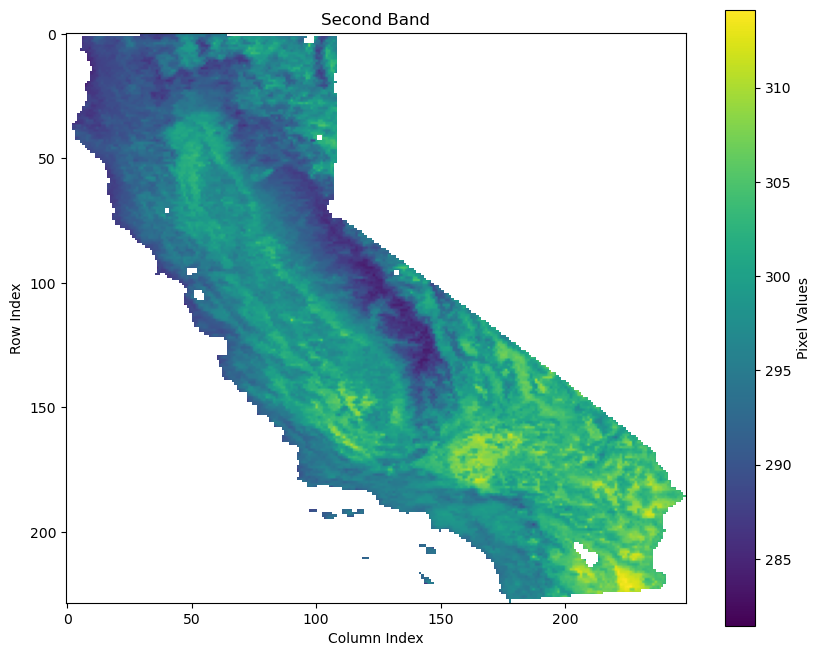

CSV file saved as reprojected_resampled_raster_with_indices.csv


In [ ]:
from rasterio.warp import calculate_default_transform, reproject, Resampling
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

file_path = "/user/xtang13/California_Multiband_Environmental_Layers_2021.tif"

# Open the raster file to read the second band
with rasterio.open(file_path) as src:
    band2 = src.read(2)  # Read the second band

# Plot the second band
plt.figure(figsize=(10, 8))
plt.imshow(band2, cmap='viridis')
plt.colorbar(label='Pixel Values')
plt.title('Second Band')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

# Define the target CRS
target_crs = 'PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137.0,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0.0],UNIT["degree",0.017453292519943295],AXIS["Longitude",EAST],AXIS["Latitude",NORTH],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["central_meridian",-96.0],PARAMETER["latitude_of_origin",23.0],PARAMETER["standard_parallel_1",29.5],PARAMETER["false_easting",0.0],PARAMETER["false_northing",0.0],PARAMETER["standard_parallel_2",45.5],UNIT["m",1.0],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'

# Open the raster file for reprojection and resampling
with rasterio.open(file_path) as src:
    # Calculate the transform and dimensions for the target resolution
    target_resolution = 200  # 200 meters
    transform, width, height = calculate_default_transform(
        src.crs, target_crs, src.width, src.height, *src.bounds, resolution=(target_resolution, target_resolution))
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': target_crs,
        'transform': transform,
        'width': width,
        'height': height,
        'nodata': src.nodata  # Ensure nodata value is carried over
    })

    # Create a new file to store the reprojected data
    reprojected_file = 'reprojected_resampled_raster.tif'
    with rasterio.open(reprojected_file, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=target_crs,
                resampling=Resampling.nearest
            )

# Convert all bands from the reprojected data to a single CSV file
with rasterio.open(reprojected_file) as src:
    num_bands = src.count
    rows, cols = src.height, src.width

    # Preallocate memory for reshaped data
    reshaped_data = np.zeros((rows * cols, num_bands), dtype=src.meta['dtype'])

    # Read and reshape each band
    for i in range(1, num_bands + 1):
        reshaped_data[:, i - 1] = src.read(i).flatten()

# Create row and column indices for each pixel
row_indices, col_indices = np.indices((rows, cols))
row_indices = row_indices.flatten()
col_indices = col_indices.flatten()

# Create a DataFrame from the reshaped data and include row and column indices
df = pd.DataFrame(reshaped_data, columns=[f'Band_{i+1}' for i in range(num_bands)])
df['Row'] = row_indices
df['Col'] = col_indices

# Rename the DataFrame columns
df.columns = ['burned', 'lst', 'humidity', 'precip', 'landcover', 'elevation', 'slope', 'aspect', 'pop_density', 'Row', 'Col']

# Save the DataFrame to a CSV file
csv_file = 'reprojected_resampled_raster_with_indices.csv'
df.to_csv(csv_file, index=False)

print(f"CSV file saved as {csv_file}")
